## Notebook for developing the smoothing-extrema-labeling method

The base idea of this method is to smooth the close-price data with some kind of rolling filter and then finding the extrema of this smoothed curve through an extrema finding method

In [21]:
import pandas as pd
import numpy as np
import ta
from database import DataBase
from utils import calculate_profit

from matplotlib import pyplot as plt
from scipy import signal
from scipy import optimize

First we initialize our database and get the close-price data

In [2]:
db = DataBase("./databases/db01")
close = db.raw_data["close"]

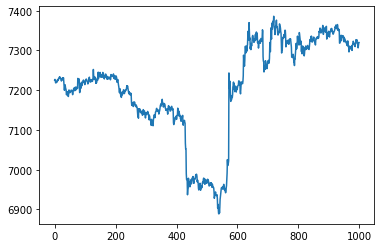

In [10]:
#only take the first 1000 rows
close = close[0:1000]
plt.plot(close)

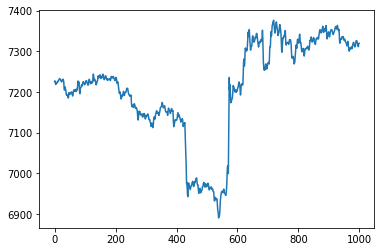

In [11]:
smoothed_close = signal.savgol_filter(x=close, window_length=5, polyorder=3)
plt.plot(smoothed_close)

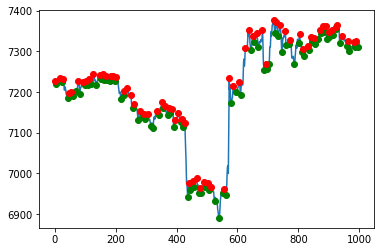

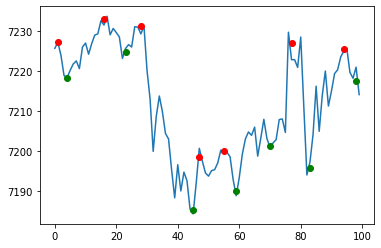

In [17]:
#get the minimas
minima_indices = signal.argrelmin(smoothed_close, order=5)
minima = np.empty(1000)
minima[:] = np.nan
minima[minima_indices] = smoothed_close[minima_indices]

#get the maximas
maxima_indices = signal.argrelmax(smoothed_close, order=5)
maxima = np.empty(1000)
maxima[:] = np.nan
maxima[maxima_indices] = smoothed_close[maxima_indices]


fig, ax = plt.subplots()
ax.plot(np.arange(0,1000,1), smoothed_close)
ax.plot(np.arange(0,1000,1), minima, marker="o", linestyle="", color="green")
ax.plot(np.arange(0,1000,1), maxima, marker="o", linestyle="", color="red")
plt.show()

fig, ax = plt.subplots()
ax.plot(np.arange(0,100,1), close[0:100])
ax.plot(np.arange(0,100,1), minima[0:100], marker="o", linestyle="", color="green")
ax.plot(np.arange(0,100,1), maxima[0:100], marker="o", linestyle="", color="red")
plt.show()

### Calculate Profit on our Labels

In [22]:
#create the labels
labels = np.zeros(1000)
labels[minima_indices] = 1
labels[maxima_indices] = 2

#create the array
array = np.zeros((1000,2))
array[:,0] = close
array[:,1] = labels

specific_profit, _ = calculate_profit(array, 0)
print(specific_profit)

0.23810637476542507


### Pack this algorithm into function and optimize parameters

In [7]:
def labeling(window_length, min_order, max_order):
    #smooth the close data
    smoothed_close = signal.savgol_filter(x=close[0:1000], window_length=window_length, polyorder=3)
    
    #get the extrema
    minima_indices = signal.argrelmin(smoothed_close, order=min_order)
    minima = np.zeros(1000)
    minima[:] = np.nan
    minima[minima_indices] = smoothed_close[minima_indices]

    maxima_indices = signal.argrelmax(smoothed_close, order=max_order)
    maxima = np.zeros(1000)
    maxima[:] = np.nan
    maxima[maxima_indices] = smoothed_close[maxima_indices]
    
    #create the labels and the profit array
    #create the labels
    labels = np.zeros(1000)
    labels[minima_indices] = 1
    labels[maxima_indices] = 2

    #create the array
    array = np.zeros((1000,2))
    array[:,0] = close[0:1000]
    array[:,1] = labels
    
    #calculate the profit
    specific_profit, _ = calculate_profit(array, 0)
    
    return specific_profit

### Optimize the function

In [11]:
optimum = -10
opt_params = [0,0]

for min_order in range(1, 100):
    for max_order in range(1, 100):
        prof = labeling(5, min_order, max_order)
        if prof > optimum:
            optimum = prof
            opt_params[0] = max_order
            opt_params[1] = min_order

print(optimum)
print(opt_params)

0.29682389370769235
[1, 1]
